<h1> <font color=#538294> Draft for general statistics (Aim#1) </font></h1>

This notebook contain drafts for analysis functions, plotting functions, and scripts for the 6OHDA project aim 1

<b>import modules:</b>

In [1]:
%matplotlib notebook 
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings

<b> Check mvmt onset, high speed, low speed period params make sense: </b> 

Note 1: need to decide between 2s and 3s for min length of mvmt period (both look o.k)
Note 2: Final params for mvmt onset = {th = 2,hi = 9,hiWin=40,thWin=30,shift=3} 
        when have time revisit the idea of deciding on thersholds for each mouse individually. 

In [ ]:
# define presentation params:
prs = Presentation()
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]

slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'high speed segments'
# define figure params:
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':9.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}
Colors = CP('highLowSpeed')
th = 3
dataPoints = 40 #(2s)

# get mice list:
miceList = getMiceList('Data_6OHDA.h5')
# prepare data storage for segments:
segs = {}
# make plot and save as ppt
for m in miceList:
    data = getData('Data_6OHDA.h5',['speed'],period ='Pre', mice=m)
    segs[m] = {};
    days = np.zeros(len(data))
    ind = 0
    # sort by session for my own OCD
    for sess in data:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    for aa in range(0,len(data)):
        sess = dKeys[a[aa]]
        speed = data[sess]['speed']['speed']
        dt  = 1/data[sess]['speed']['Fs']
        if ind%3==0:
            fig, ax = plt.subplots(3,1,figsize=(lf['width'],lf['height']),
                                   gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
            fig.set_size_inches(lf['width'],lf['height'],forward=True)
            slide = prs.slides.add_slide(title_layout)
            slide.shapes.title.text = m + 'params: th='+ str(th) + ' #points='+ str(dataPoints)
        try:    
            segs[m][sess] = HighSpeedPeriods(ax[ind%3],speed.T,dt,th, dataPoints, Colors['high'])
        except:
            print('error')
        ax[ind%3].set_title(sess)
        if ind%3==2 or aa ==len(data)-1:
            pic = plt2pptx(slide, fig, **fArgs)
            plt.close(fig)
        ind = ind+1
prs.save('ppts/highMvmtSeg.pptx')


In [54]:
%xdel prs

In [ ]:
# define presentation params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]

slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'Mvmt onset'
# define figure params:
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}
Colors = CP('mvmtType')
th = 2
hi = 9 
hiWin=40 
thWin=30
shift=3

# get mice list:
miceList = getMiceList('Data_6OHDA.h5')
# prepare data storage for segments:
# make plot and save as ppt
for m in miceList:
    data = getData('Data_6OHDA.h5',['speed'],period ='Pre', mice=m)
    days = np.zeros(len(data))
    ind = 0
    # sort by session for my own OCD
    for sess in data:
        if sess[5] == 'B':
            day = 0
        else:
            day = int(re.findall(r'\d+',sess[5:])[0])
        days[ind] = day
        ind= ind+1
    a = np.argsort(days)
    dKeys = list(data.keys())
    # calculte high speed period, do 3 sessions per plot, and stor in ppt
    ind = 0;
    for aa in range(0,len(data)):
        sess = dKeys[a[aa]]
        speed = data[sess]['speed']['speed']
        speed = speed.T
        smoothSpeed = smooth(speed,20)
        dt  = 1/data[sess]['speed']['Fs']
        if ind%3==0:
            fig, ax = plt.subplots(3,1,figsize=(lf['width'],lf['height']),
                                   gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.1})
            fig.set_size_inches(lf['width'],lf['height'],forward=True)
            fig.subplots_adjust(left=0.03, right=0.99)
            slide = prs.slides.add_slide(title_layout)
            slide.shapes.title.text = m + 'params: th='+ str(th) + ' hi='+ str(hi)
        try:    
            sOnset = FindMvmtOnset(speed,th,hi,hiWin,thWin, shift)
            t = np.linspace(0,len(speed)*dt,len(speed))
            ax[ind%3].plot(t,speed)
            ax[ind%3].plot(t,smoothSpeed, color='black')
            ax[ind%3].plot(t[sOnset],smoothSpeed[sOnset],'X',color='firebrick')
            ax[ind%3].set_xlim(0,600)
        except:
            print('error')
        ax[ind%3].set_title(sess)
        if ind%3==2 or aa ==len(data)-1:
            pic = plt2pptx(slide, fig, **fArgs)
            plt.close(fig)
        ind = ind+1
prs.save('ppts/SpeedOnset_final_hi9_th2_hiwin40.pptx')



<b> align Ca activity to mvmt onset </b>

In [4]:
# get data: 
PVdataH = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
PVdataP = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x>0)
MSNdataH = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre',red = False,day = lambda x: x==0)
MSNdataP = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre',red = False,day = lambda x: x>0)
CHIdataH = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)
CHIdataP = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x>0)


cleaning up trace data
I deleted session: 1236_BaselineL
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
I deleted session: 8430_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1236_day19L
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9
I deleted session: 4539_day5
I deleted session: 7909_day30A
I deleted session: 8430_day1
I deleted session: 8430_day9
I deleted session: 8803_day10
I deleted session: 8803_day12
I deleted session: 8803_day2
I deleted session: 8803_day30A
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1253_BaselineS
I deleted session: 2980_BaselineL
cleaning up speed data
cleaning up trace data
I deleted session: 2980_day30A
I deleted session: 2981_day30A
I deleted session: 2981_day4
I deleted session: 8815_day10
cleaning up speed data
cleaning up trace data
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I d

<IPython.core.display.Javascript object>


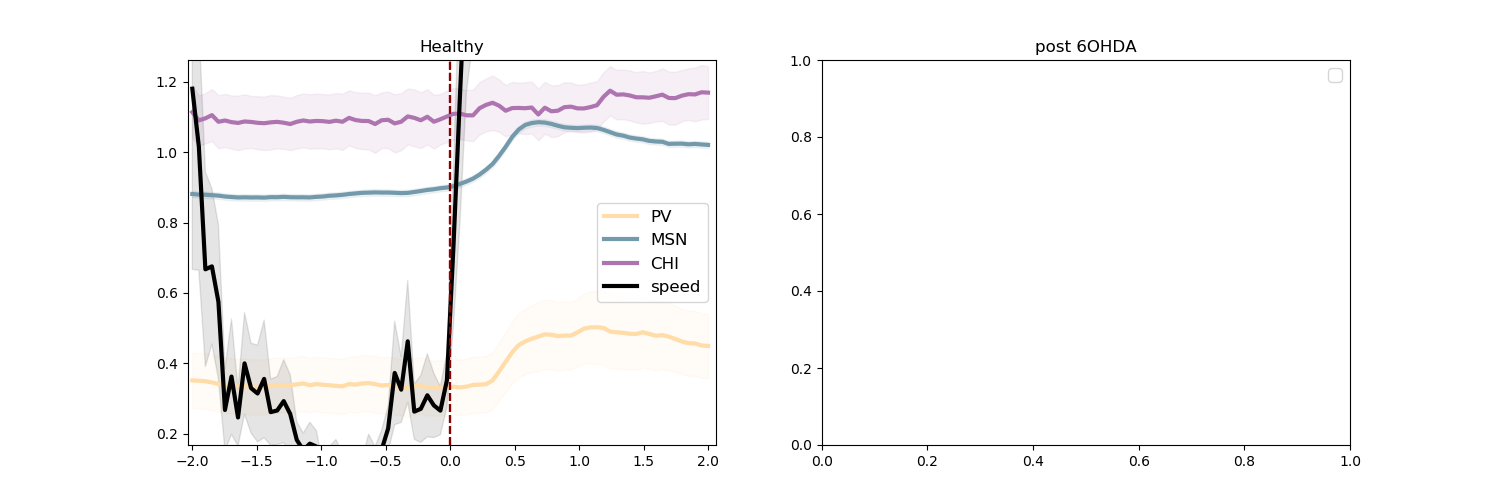

/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
No handles with labels found to put in legend.


Text(0.5,1,'post 6OHDA')

In [5]:
# intialize figure and colors:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['PVdataH','MSNdataH','CHIdataH']
Names = {'PVdataH':'PV - healthy','PVdataP':'PV - post 6OHDA',
         'MSNdataH':'MSN - healthy','MSNdataP':'MSN - post 6OHDA',
         'CHIdataH':'CHI - healthy','CHIdataP':'CHI - post 6OHDA'}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 40 #2s
PostS = 40 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)

# set mvmt onset params: 
th = 2
hi = 9 
hiWin=40 
thWin=30
shift=0

for c in cond:
    data = eval(c)
    for s in data.keys():
        speed = data[s]['speed']['speed'].T
        dff = data[s]['trace']['dff']
        # Vectors are saved as column vectors so.. transposed to raw vector
        if dff.shape[1] == 1:
            dff = dff.T
                
        sOnset = FindMvmtOnset(speed,th,hi,hiWin,thWin, shift)        
        sA = alignToOnset(dff.T, sOnset, winPost=PostS,winPre=preS)       
        if len(sA.shape) > 2:
            sA = np.mean(sA,2)
            if 'sAligned' not in locals():
#               print(s+' :',sA.shape)
                sAligned = sA
            else:
#                print(s+' :',sA.shape,sAligned.shape)
                sAligned = np.concatenate((sAligned,sA),axis=1)

    if c[-1]=='H':
        PlotRelativeToOnset(ax[0],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
        sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
        if sS.ndim > 1:
            if 'sAlignedS' not in locals():
    #           print(s+' :',sA.shape)
                sAlignedS = sS
            else:
#                print(s+' :',cAs.shape,caAlignedS.shape)
                sAlignedS = np.concatenate((sAlignedS,sS),axis=1)
    else: 
        PlotRelativeToOnset(ax[1],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
        sSP = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
        if sS.ndim > 1:
            if 'sAlignedSP' not in locals():
    #           print(s+' :',sA.shape)
                sAlignedSP = sSP
            else:
#                print(s+' :',cAs.shape,caAlignedS.shape)
                sAlignedSP = np.concatenate((sAlignedSP,sSP),axis=1)
    del sAligned
#PlotRelativeToOnset(ax[1],sAlignedSP,tPlot,Color='black',Label='speed',mesErr=True)
PlotRelativeToOnset(ax[0],sAlignedS,tPlot,Color='black',Label='speed',mesErr=True)
ax[0].legend(fontsize=12)
ax[0].set_title('Healthy')
ax[1].legend(fontsize=12)
ax[1].set_title('post 6OHDA')

<IPython.core.display.Javascript object>


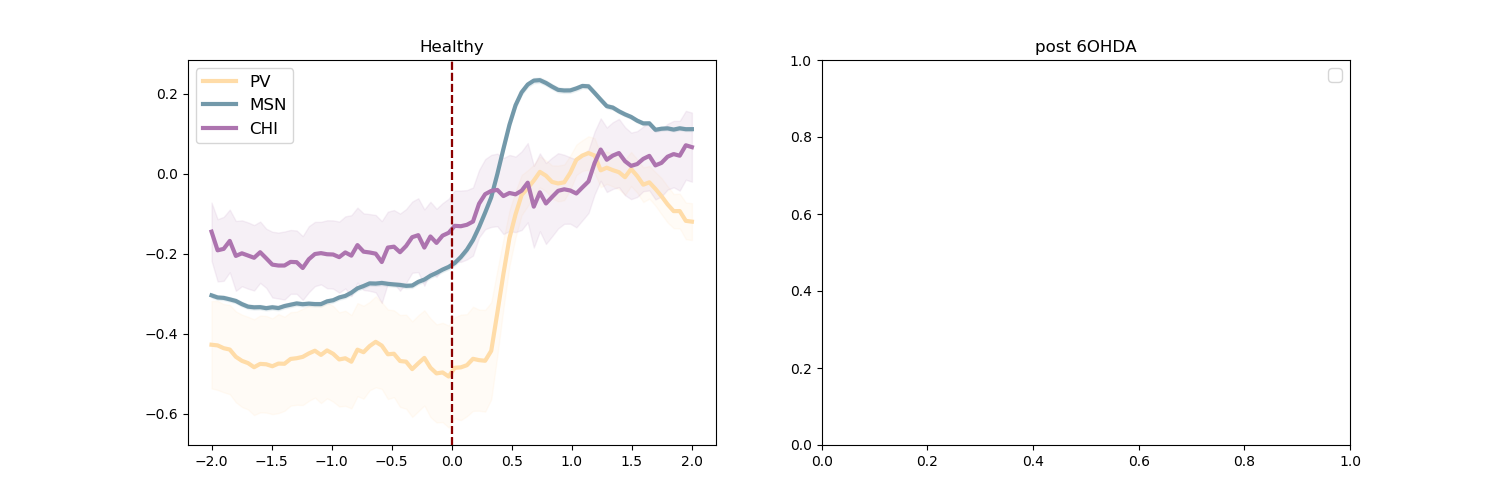

/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


Text(0.5,1,'post 6OHDA')

In [6]:
# intialize figure and colors:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
Colors = CP('creType')

#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['PVdataH','MSNdataH','CHIdataH']
Names = {'PVdataH':'PV - healthy','PVdataP':'PV - post 6OHDA',
         'MSNdataH':'MSN - healthy','MSNdataP':'MSN - post 6OHDA',
         'CHIdataH':'CHI - healthy','CHIdataP':'CHI - post 6OHDA'}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 40 #2s
PostS = 40 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)

# set mvmt onset params: 
th = 2
hi = 9 
hiWin=40 
thWin=30
shift=0

for c in cond:
    data = eval(c)
    for s in data.keys():
        speed = data[s]['speed']['speed'].T
        dff = data[s]['trace']['dff']
        # Vectors are saved as column vectors so.. transposed to raw vector
        if dff.shape[1] == 1:
            dff = dff.T
        # Z-score dff
        mu = np.mean(dff,axis=1)
        std = np.std(dff,axis=1)
        Zdff = (dff.T-mu.T)/std.T
        Zdff = Zdff.T  
        
        
        sOnset = FindMvmtOnset(speed,th,hi,hiWin,thWin, shift)        
        sA = alignToOnset(Zdff.T, sOnset, winPost=PostS,winPre=preS)       
        if len(sA.shape) > 2:
            sA = np.mean(sA,2)
            if 'sAligned' not in locals():
#               print(s+' :',sA.shape)
                sAligned = sA
            else:
#                print(s+' :',sA.shape,sAligned.shape)
                sAligned = np.concatenate((sAligned,sA),axis=1)

    if c[-1]=='H':
        PlotRelativeToOnset(ax[0],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
#    else: 
#        PlotRelativeToOnset(ax[1],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
    del sAligned
ax[0].legend(fontsize=12)
ax[0].set_title('Healthy')
ax[1].legend(fontsize=12)
ax[1].set_title('post 6OHDA')

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 0761_BaselineL
I deleted session: 0761_BaselineS
cleaning up speed data
cleaning up trace data
I deleted session: 0761_day10
cleaning up speed data
cleaning up trace data
I deleted session: 0761_BaselineL
I deleted session: 0761_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 0761_day1
I deleted session: 0761_day10
I deleted session: 0761_day14A
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


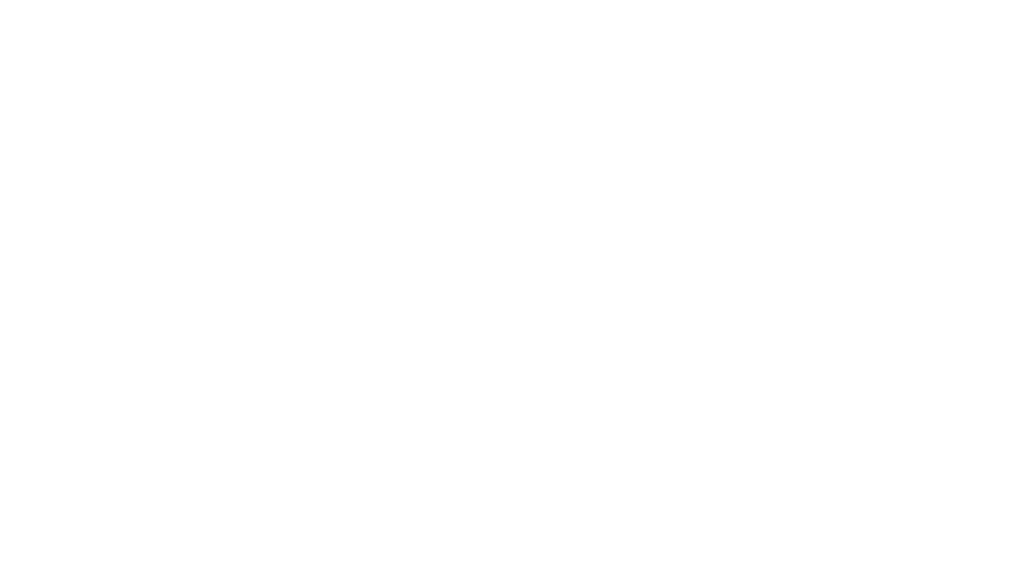

/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1208_day19L
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1208_day19L
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


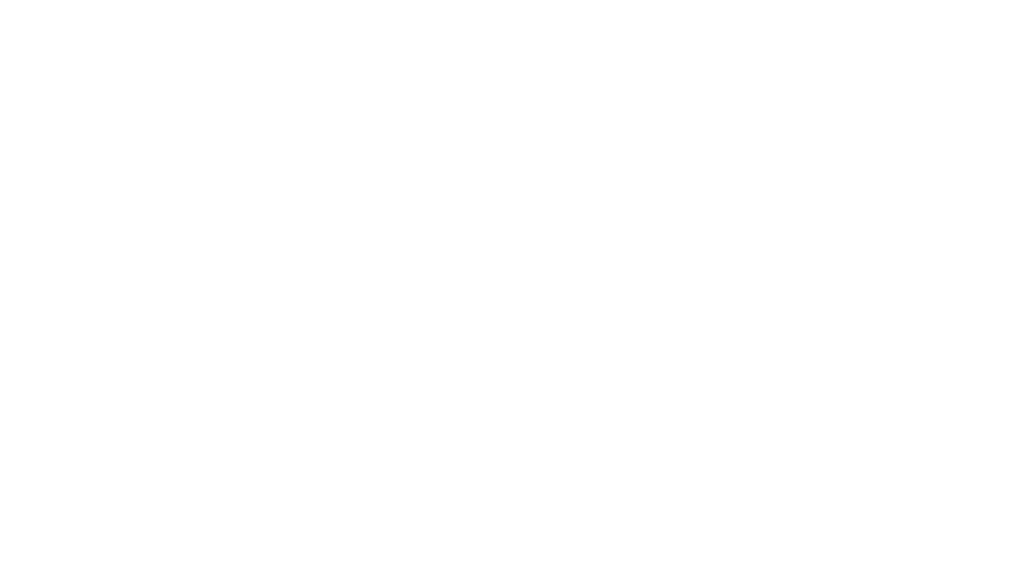

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1222_day2
I deleted session: 1222_day3
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1222_day11
I deleted session: 1222_day13
I deleted session: 1222_day2
I deleted session: 1222_day3
I deleted session: 1222_day32A
I deleted session: 1222_day36L
I deleted session: 1222_day5
I deleted session: 1222_day7
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


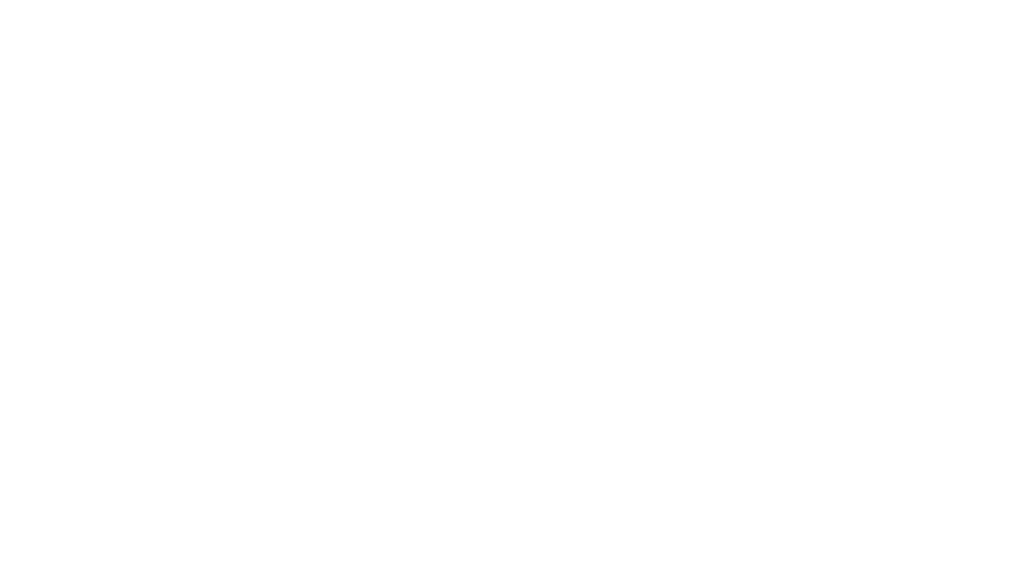

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


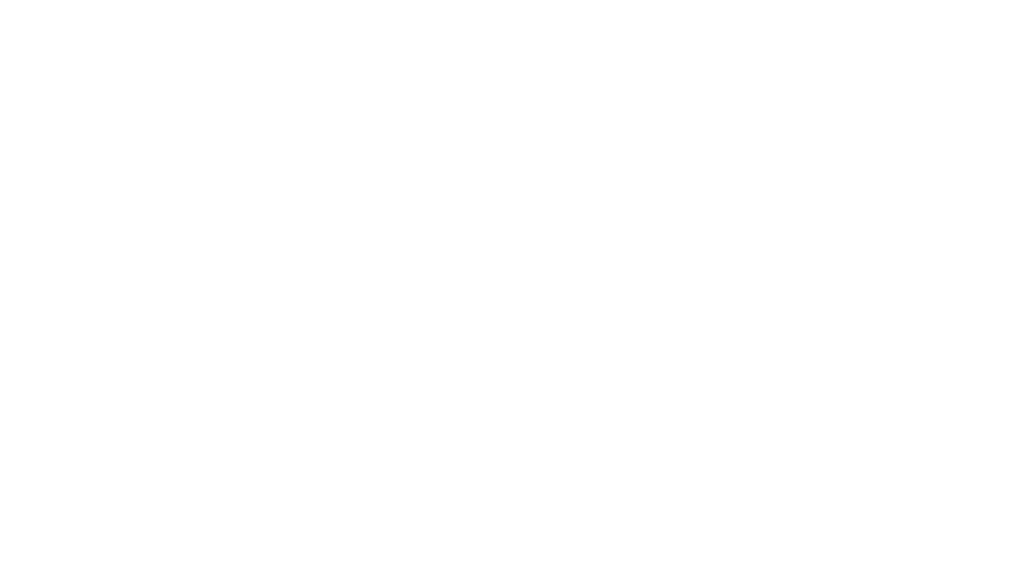

No handles with labels found to put in legend.


cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


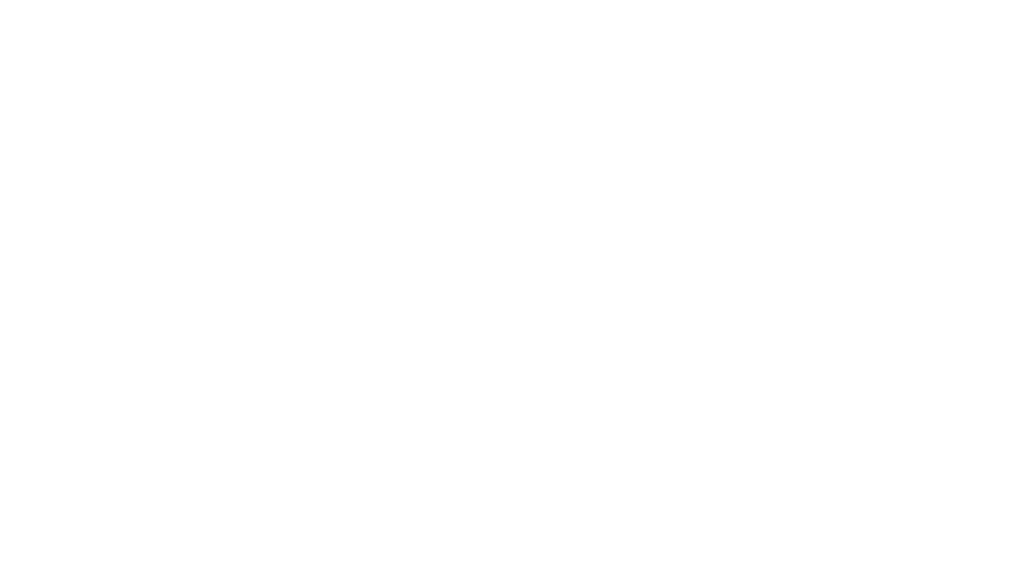

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1253_BaselineS
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1253_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


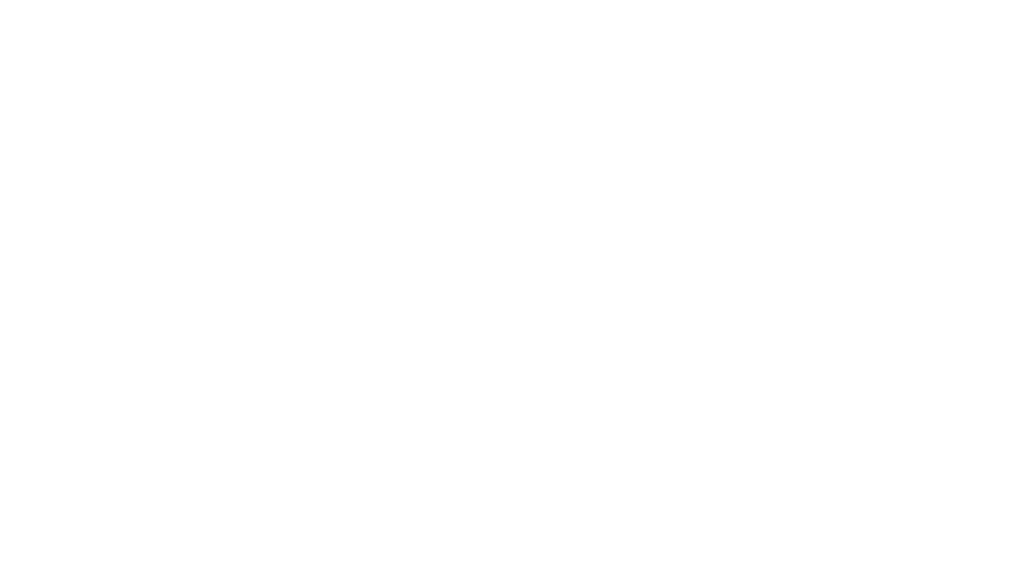

No handles with labels found to put in legend.


cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1793_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1793_day10
I deleted session: 1793_day12
I deleted session: 1793_day14
I deleted session: 1793_day15A
I deleted session: 1793_day19L
I deleted session: 1793_day30A
I deleted session: 1793_day34L
I deleted session: 1793_day6
I deleted session: 1793_day8
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


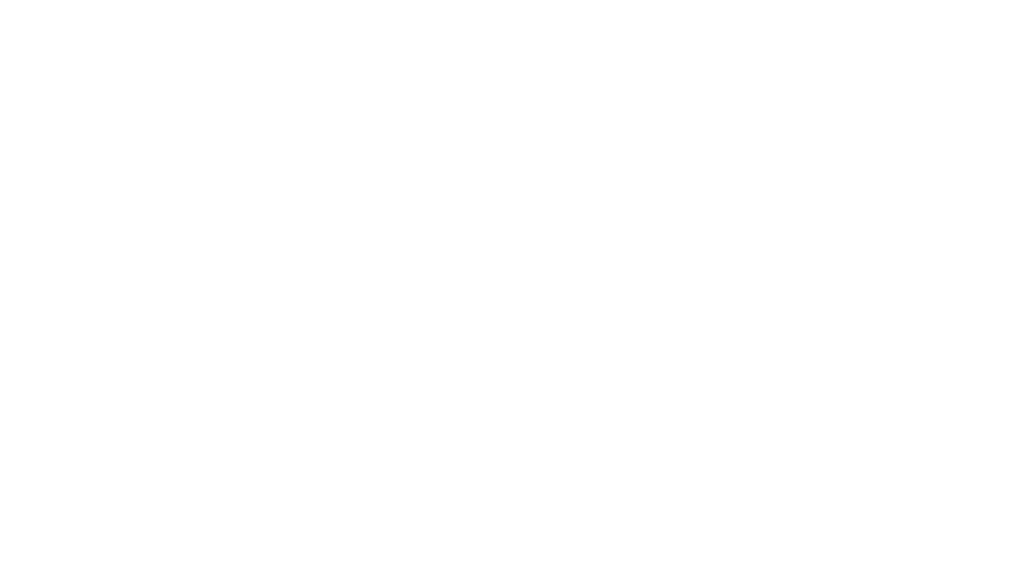

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 2976_day4
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


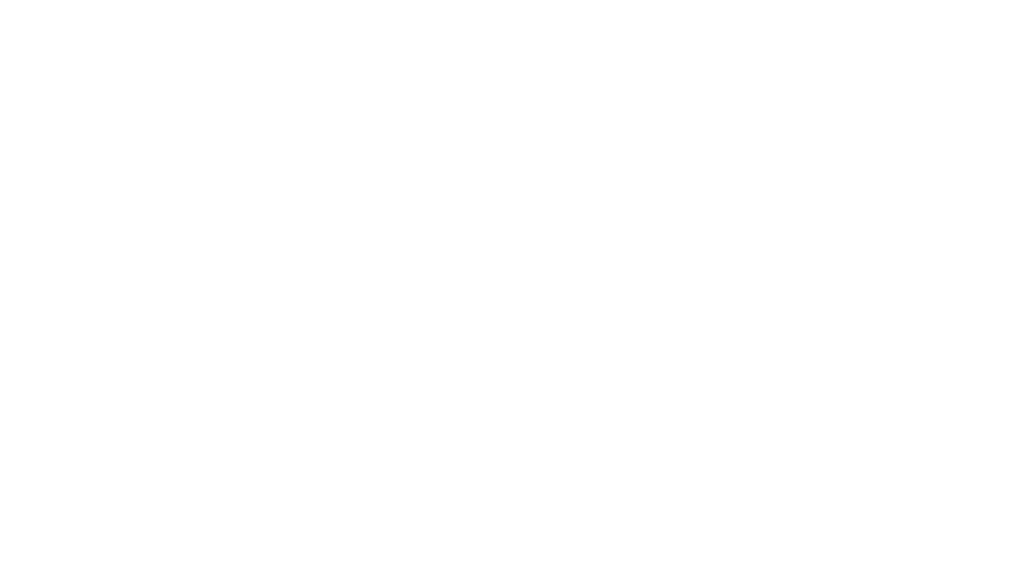

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 2980_BaselineL
cleaning up speed data
cleaning up trace data
I deleted session: 2980_day30A
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


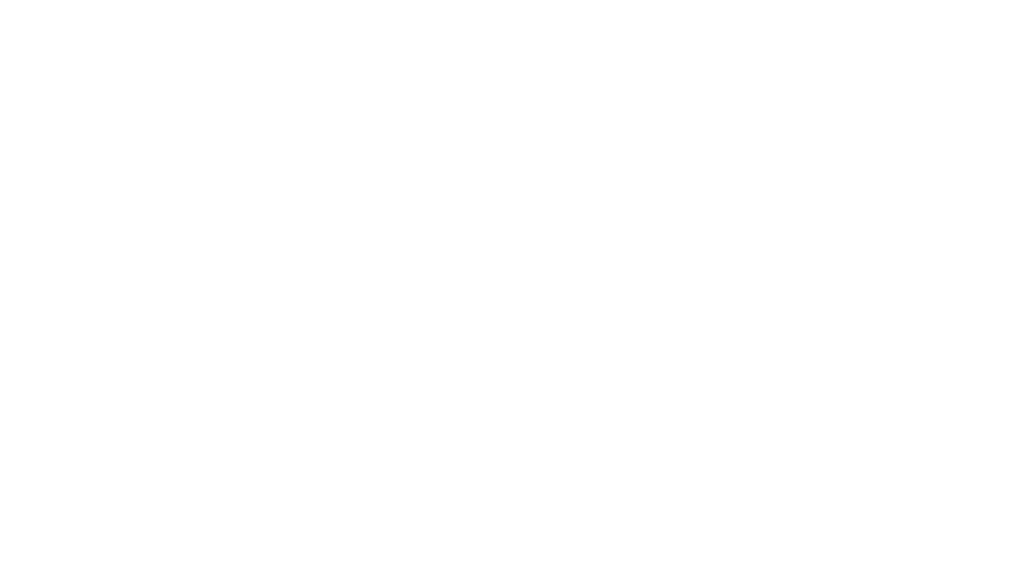

/home/dana_z/ssd_2TB/6OHDA/plotUtils.py:47: RuntimeWarning: Mean of empty slice
  d = np.nanmean(aligned,axis=1)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 2981_day30A
I deleted session: 2981_day4
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


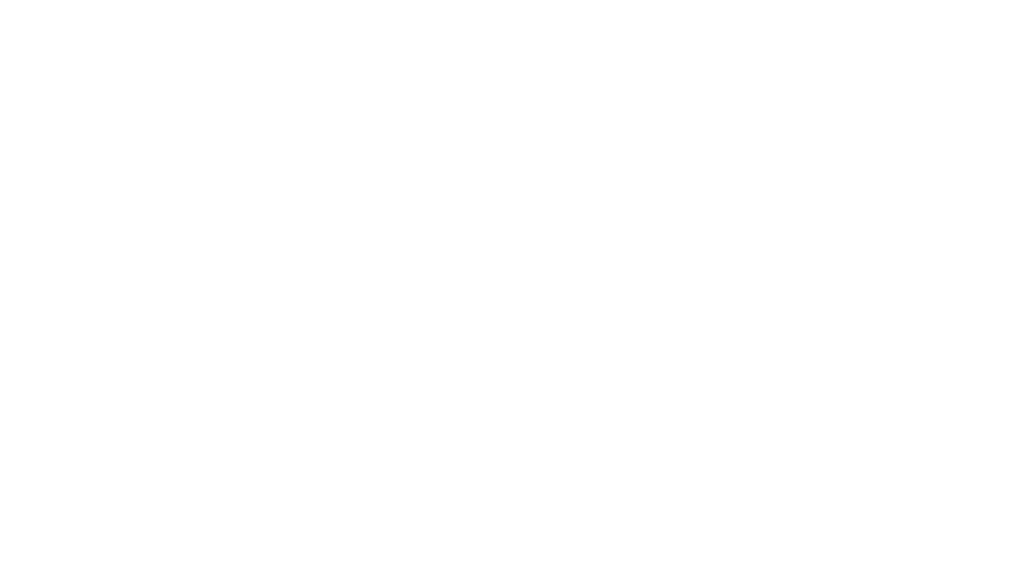

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 4539_day13
I deleted session: 4539_day4
I deleted session: 4539_day5
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 4539_day13
I deleted session: 4539_day4
I deleted session: 4539_day5
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


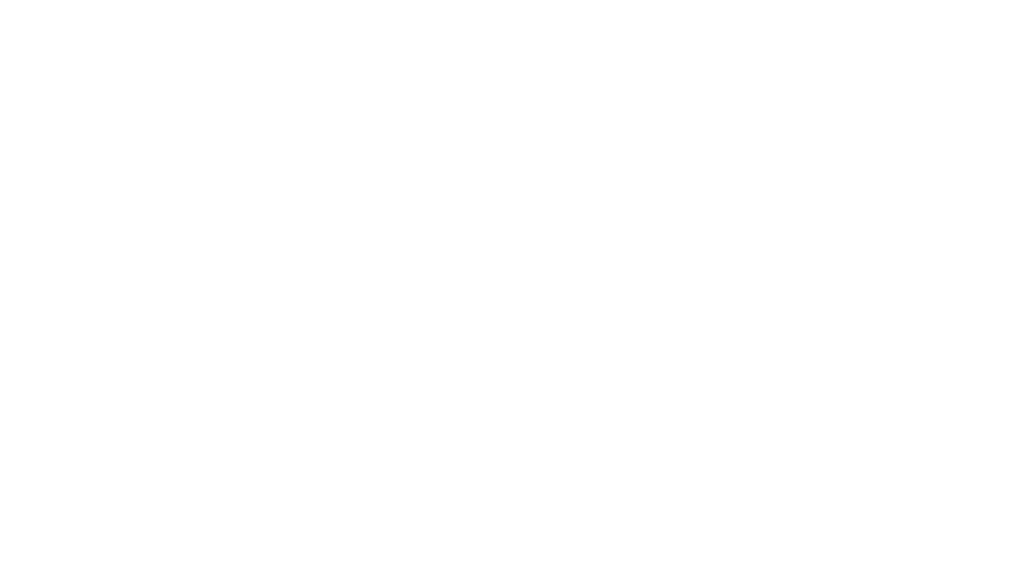

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day30A
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day30A
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


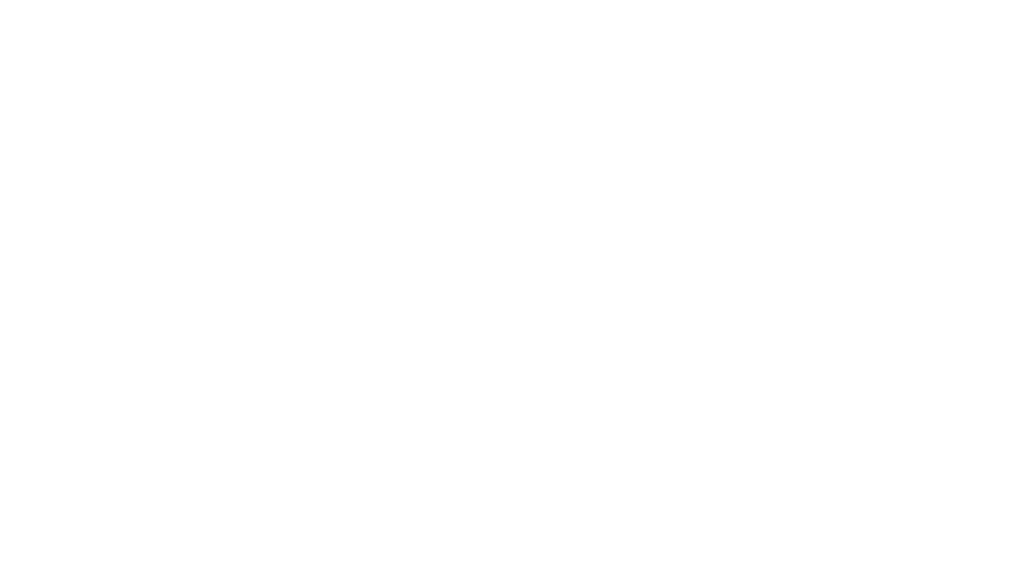

No handles with labels found to put in legend.


cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 7909_day13
I deleted session: 7909_day30A
I deleted session: 7909_day6
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 7909_day13
I deleted session: 7909_day6
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


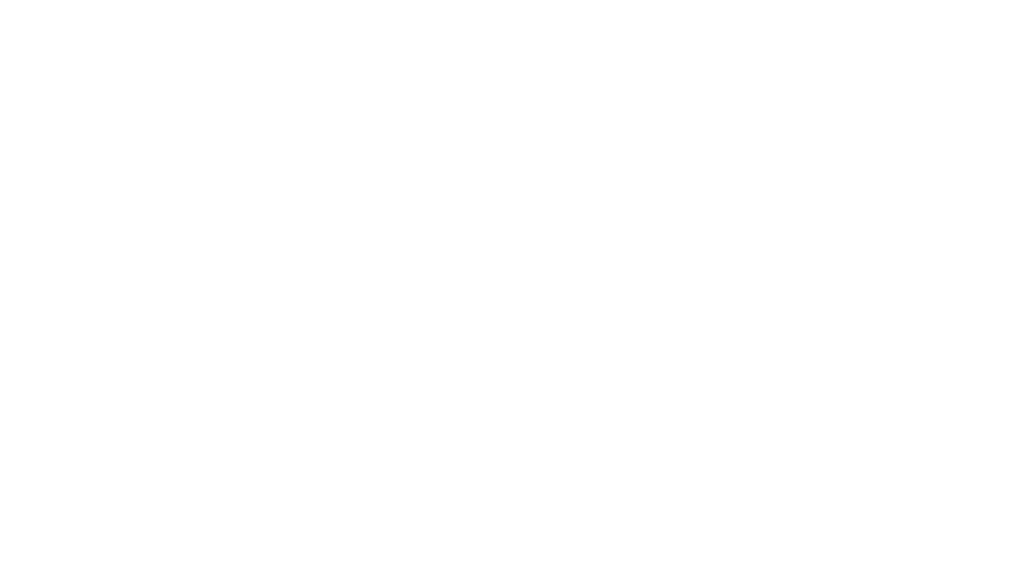

No handles with labels found to put in legend.


cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 8430_day1
I deleted session: 8430_day13
I deleted session: 8430_day15A
I deleted session: 8430_day9
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 8430_day13
I deleted session: 8430_day15A
I deleted session: 8430_day9
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


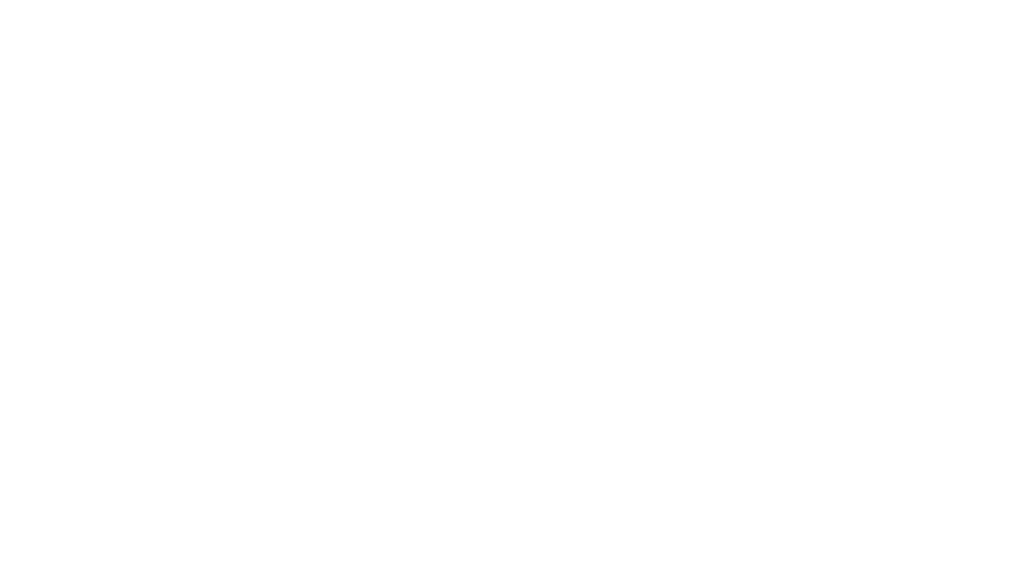

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 8803_day12
I deleted session: 8803_day19L
I deleted session: 8803_day5
I deleted session: 8803_day6
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 8803_day5
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


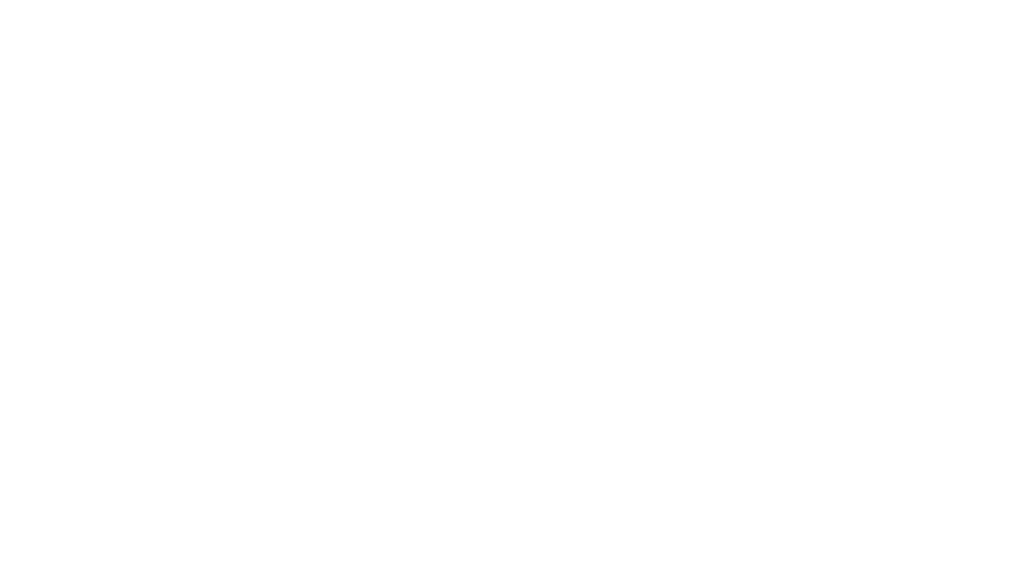

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 8815_day10
I deleted session: 8815_day15A
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 8815_day10
I deleted session: 8815_day15A
I deleted session: 8815_day2
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


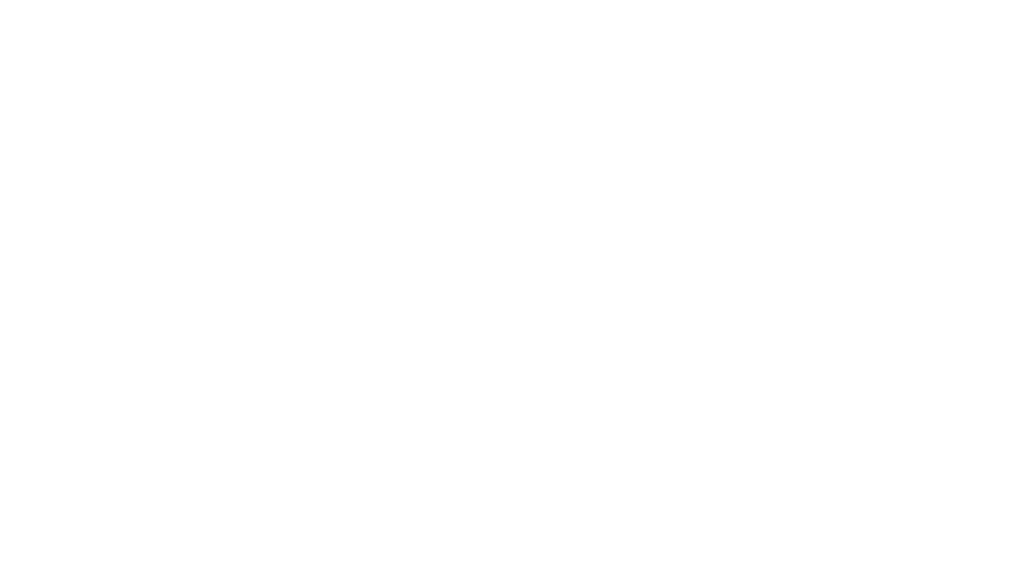

In [126]:
# define presentation params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]

slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'Ca Aligned to mvmt onset'
# define figure params:
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

Colors = CP('creType')

cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
Names = {'PVdataH':'PV - healthy','PVdataP':'PV - post 6OHDA',
         'MSNdataH':'MSN - healthy','MSNdataP':'MSN - post 6OHDA',
         'CHIdataH':'CHI - healthy','CHIdataP':'CHI - post 6OHDA'}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 40 #2s
PostS = 40 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)

# set mvmt onset params: 
th = 2
hi = 9 
hiWin=40 
thWin=30
shift=1

# get mice list:
miceList = getMiceList('Data_6OHDA.h5')
# prepare data storage for segments:
# make plot and save as ppt
for m in miceList:
    PVdataH = getData('Data_6OHDA.h5',['speed','trace'],period ='Pre', cre='PV', mice=m,red = True,day = lambda x: x==0)
    PVdataP = getData('Data_6OHDA.h5',['speed','trace'],period ='Pre', cre='PV', mice=m,red = True,day = lambda x: x>0)
    MSNdataH = getData('Data_6OHDA.h5',['speed','trace'],period ='Pre',red = False, mice=m,day = lambda x: x==0)
    MSNdataP = getData('Data_6OHDA.h5',['speed','trace'],period ='Pre',red = False, mice=m,day = lambda x: x>0)
    CHIdataH = getData('Data_6OHDA.h5',['speed','trace'],period ='Pre', cre='CHI',red = True, mice=m,day = lambda x: x==0)
    CHIdataP = getData('Data_6OHDA.h5',['speed','trace'],period ='Pre', cre='CHI',red = True, mice=m,day = lambda x: x>0)
    
    fig, ax = plt.subplots(1,2,figsize=(lf['width'],lf['height']),
                           gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.1})
    fig.set_size_inches(lf['width'],lf['height'],forward=True)
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m + ' Z-score dff'
    
    for c in cond:
        data = eval(c)
        for s in data.keys():
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            # Z-score dff
#            mu = np.mean(dff,axis=1)
#            std = np.std(dff,axis=1)
#            Zdff = (dff.T-mu.T)/std.T
#            Zdff = Zdff.T  

            sOnset = FindMvmtOnset(speed,th,hi,hiWin,thWin, shift)        
            sA = alignToOnset(dff.T, sOnset, winPost=PostS,winPre=preS)       
            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
    #               print(s+' :',sA.shape)
                    sAligned = sA
                else:
    #                print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)
        if len(data.keys())==0:
            continue
        if c[-1]=='H':
            PlotRelativeToOnset(ax[0],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
        else: 
            PlotRelativeToOnset(ax[1],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
        del sAligned
    ax[0].legend(fontsize=12)
    ax[0].set_title('Healthy')
    ax[1].legend(fontsize=12)
    ax[1].set_title('post 6OHDA')
    pic = plt2pptx(slide, fig, **fArgs)
    plt.close(fig)

prs.save('ppts/dff2mvmt_onset.pptx')

In [16]:
%xdel sAligned

In [13]:
Colors = CP('creType')
print(Colors)

{'MSN': [0.451, 0.6, 0.667], 'MSN_std': [0.753, 0.827, 0.863], 'CHI': [0.678, 0.455, 0.686], 'CHI_std': [0.867, 0.753, 0.871], 'PV': [1, 0.863, 0.659], 'PV_std': [1, 0.945, 0.867]}


cleaning up trace data
I deleted session: 1236_BaselineL
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
I deleted session: 8430_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1253_BaselineS
cleaning up speed data
cleaning up trace data
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
I deleted session: 1793_BaselineA
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


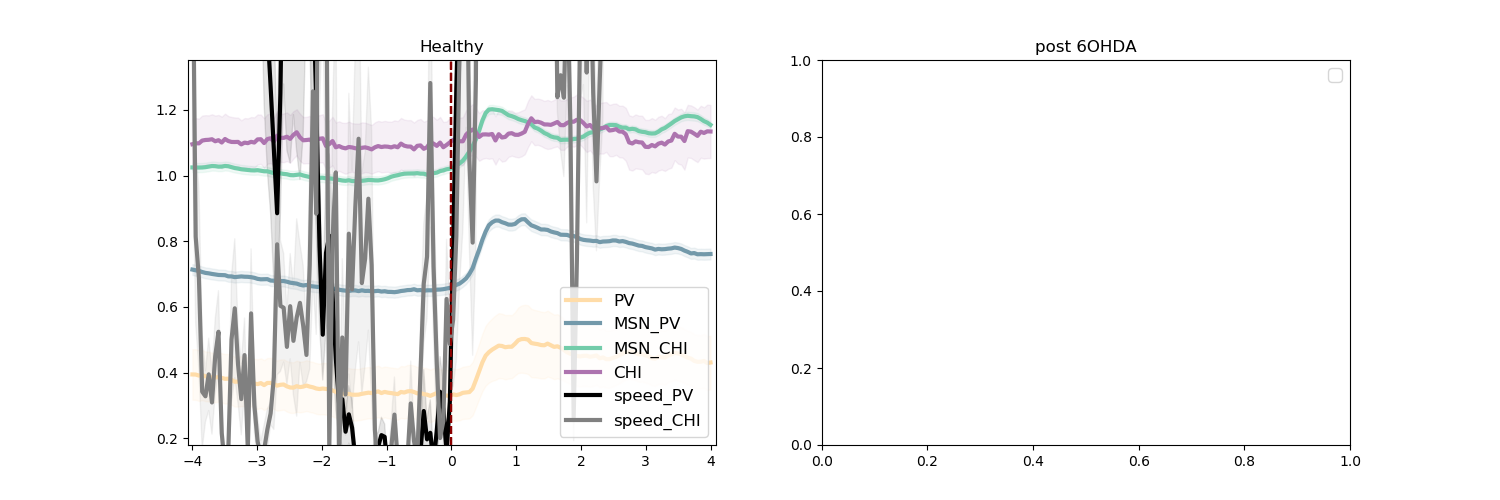

/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
No handles with labels found to put in legend.


Text(0.5,1,'post 6OHDA')

In [7]:
PVdataH = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
MSN_PVdataH = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='PV',red = False,day = lambda x: x==0)
MSN_CHIdataH = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='CHI',red = False,day = lambda x: x==0)
CHIdataH = getData('Data_6OHDA_H_all.h5',['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)




# intialize figure and colors:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
Colors = CP('creType')
Colors['MSN_PV'] = Colors['MSN']
Colors['MSN_CHI'] =[0.451, 0.8, 0.667]


#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['PVdataH','MSN_PVdataH','MSN_CHIdataH','CHIdataH']
Names = {'PVdataH':'PV - healthy','PVdataP':'PV - post 6OHDA',
         'MSNdataH':'MSN - healthy','MSNdataP':'MSN - post 6OHDA',
         'CHIdataH':'CHI - healthy','CHIdataP':'CHI - post 6OHDA'}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)

# set mvmt onset params: 
th = 2
hi = 9 
hiWin=40 
thWin=30
shift=0

for c in cond:
    data = eval(c)
    for s in data.keys():
        speed = data[s]['speed']['speed'].T
        dff = data[s]['trace']['dff']
        # Vectors are saved as column vectors so.. transposed to raw vector
        if dff.shape[1] == 1:
            dff = dff.T
                
        sOnset = FindMvmtOnset(speed,th,hi,hiWin,thWin, shift)        
        sA = alignToOnset(dff.T, sOnset, winPost=PostS,winPre=preS)       
        if len(sA.shape) > 2:
            sA = np.mean(sA,2)
            if 'sAligned' not in locals():
#               print(s+' :',sA.shape)
                sAligned = sA
            else:
#                print(s+' :',sA.shape,sAligned.shape)
                sAligned = np.concatenate((sAligned,sA),axis=1)


    PlotRelativeToOnset(ax[0],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
    if c in ['PVdataH','MSN_PVdataH']:
        if sS.ndim > 1:
            if 'sAlignedSPV' not in locals():
                sAlignedSPV = sS
            else:
                sAlignedSPV = np.concatenate((sAlignedSPV,sS),axis=1)
    else:
        if sS.ndim > 1:
            if 'sAlignedSCHI' not in locals():
                sAlignedSCHI = sS
            else:
                sAlignedSCHI = np.concatenate((sAlignedSCHI,sS),axis=1)
        
    del sAligned
#PlotRelativeToOnset(ax[1],sAlignedSP,tPlot,Color='black',Label='speed',mesErr=True)
PlotRelativeToOnset(ax[0],sAlignedSPV,tPlot,Color='black',Label='speed_PV',mesErr=True)
PlotRelativeToOnset(ax[0],sAlignedSCHI,tPlot,Color='gray',Label='speed_CHI',mesErr=True)
ax[0].legend(fontsize=12)
ax[0].set_title('Healthy')
ax[1].legend(fontsize=12)
ax[1].set_title('post 6OHDA')

cleaning up trace data
I deleted session: 1236_BaselineL
I deleted session: 4539_Baseline2A
I deleted session: 7584_day0
I deleted session: 8430_BaselineA
I deleted session: 8430_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 4539_Baseline2A
cleaning up speed data
cleaning up trace data
I deleted session: 0761_BaselineA
I deleted session: 1253_BaselineS
cleaning up speed data
cleaning up trace data
I deleted session: 0761_BaselineA
I deleted session: 1208_BaselineA
I deleted session: 1222_BaselineA
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
I deleted session: 1793_BaselineA
I deleted session: 1793_BaselineS
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


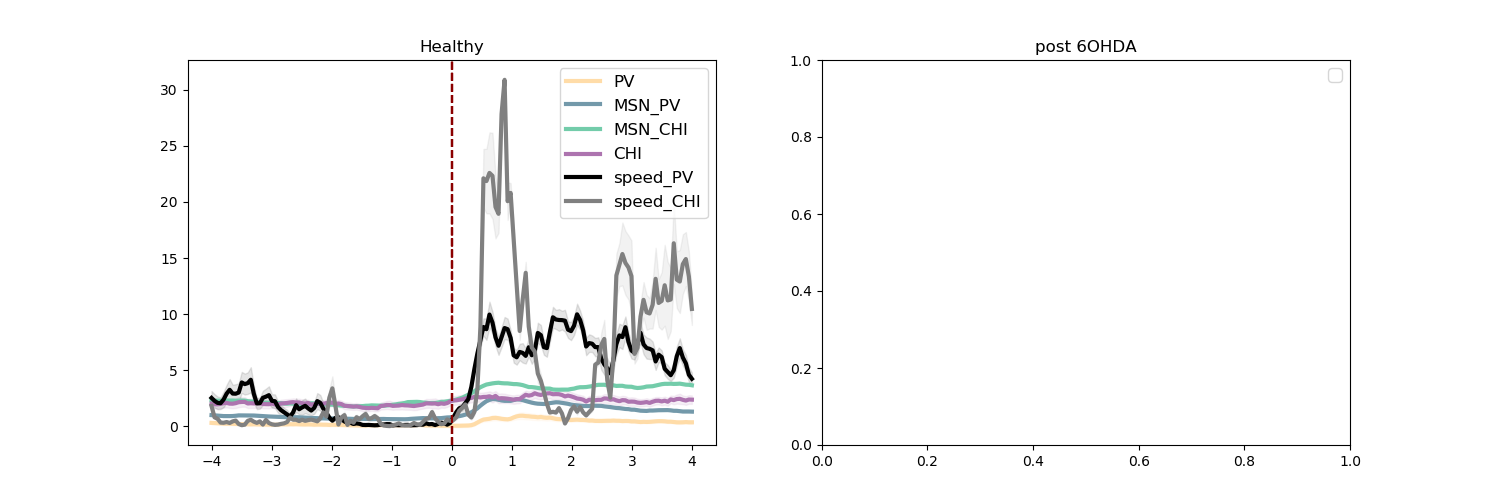

/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
No handles with labels found to put in legend.


Text(0.5,1,'post 6OHDA')

In [45]:
PVdataH = getData('Data_6OHDA_Hc.h5',['speed','trace'],period ='Pre', cre='PV',red = True,day = lambda x: x==0)
MSN_PVdataH = getData('Data_6OHDA_Hc.h5',['speed','trace'],period ='Pre', cre='PV',red = False,day = lambda x: x==0)
MSN_CHIdataH = getData('Data_6OHDA_Hc.h5',['speed','trace'],period ='Pre', cre='CHI',red = False,day = lambda x: x==0)
CHIdataH = getData('Data_6OHDA_Hc.h5',['speed','trace'],period ='Pre', cre='CHI',red = True,day = lambda x: x==0)




# intialize figure and colors:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
Colors = CP('creType')
Colors['MSN_PV'] = Colors['MSN']
Colors['MSN_CHI'] =[0.451, 0.8, 0.667]


#cond = ['PVdataH','PVdataP','MSNdataH','MSNdataP','CHIdataH','CHIdataP']
cond = ['PVdataH','MSN_PVdataH','MSN_CHIdataH','CHIdataH']
Names = {'PVdataH':'PV - healthy','PVdataP':'PV - post 6OHDA',
         'MSNdataH':'MSN - healthy','MSNdataP':'MSN - post 6OHDA',
         'CHIdataH':'CHI - healthy','CHIdataP':'CHI - post 6OHDA'}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)

# set mvmt onset params: 
th = 2
hi = 9 
hiWin=40 
thWin=30
shift=0

for c in cond:
    data = eval(c)
    for s in data.keys():
        speed = data[s]['speed']['speed'].T
        dff = data[s]['trace']['dff']
        # Vectors are saved as column vectors so.. transposed to raw vector
        if dff.shape[1] == 1:
            dff = dff.T
                
        sOnset = FindMvmtOnset(speed,th,hi,hiWin,thWin, shift)        
        sA = alignToOnset(dff.T, sOnset, winPost=PostS,winPre=preS)       
        if len(sA.shape) > 2:
            sA = np.mean(sA,2)
            if 'sAligned' not in locals():
#               print(s+' :',sA.shape)
                sAligned = sA
            else:
#                print(s+' :',sA.shape,sAligned.shape)
                sAligned = np.concatenate((sAligned,sA),axis=1)


    PlotRelativeToOnset(ax[0],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
    sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
    if c in ['PVdataH','MSN_PVdataH']:
        if sS.ndim > 1:
            if 'sAlignedSPV' not in locals():
                sAlignedSPV = sS
            else:
                sAlignedSPV = np.concatenate((sAlignedSPV,sS),axis=1)
    else:
        if sS.ndim > 1:
            if 'sAlignedSCHI' not in locals():
                sAlignedSCHI = sS
            else:
                sAlignedSCHI = np.concatenate((sAlignedSCHI,sS),axis=1)
        
    del sAligned
#PlotRelativeToOnset(ax[1],sAlignedSP,tPlot,Color='black',Label='speed',mesErr=True)
PlotRelativeToOnset(ax[0],sAlignedSPV,tPlot,Color='black',Label='speed_PV',mesErr=True)
PlotRelativeToOnset(ax[0],sAlignedSCHI,tPlot,Color='gray',Label='speed_CHI',mesErr=True)
ax[0].legend(fontsize=12)
ax[0].set_title('Healthy')
ax[1].legend(fontsize=12)
ax[1].set_title('post 6OHDA')

cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 0761_BaselineA
cleaning up speed data
cleaning up trace data
I deleted session: 0761_BaselineA
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


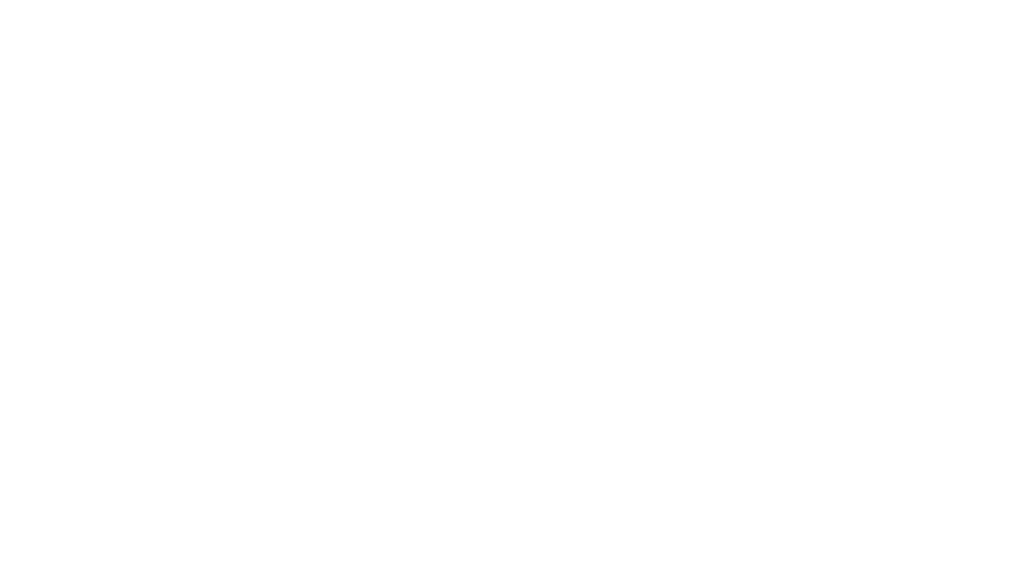

(160, 35, 7)
0761_BaselineL : (160, 35)
(160, 32, 10)
0761_BaselineS : (160, 32) (160, 35)
(160, 7)
(160, 10)
CHIdataH (1, 11900)
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1208_BaselineA
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


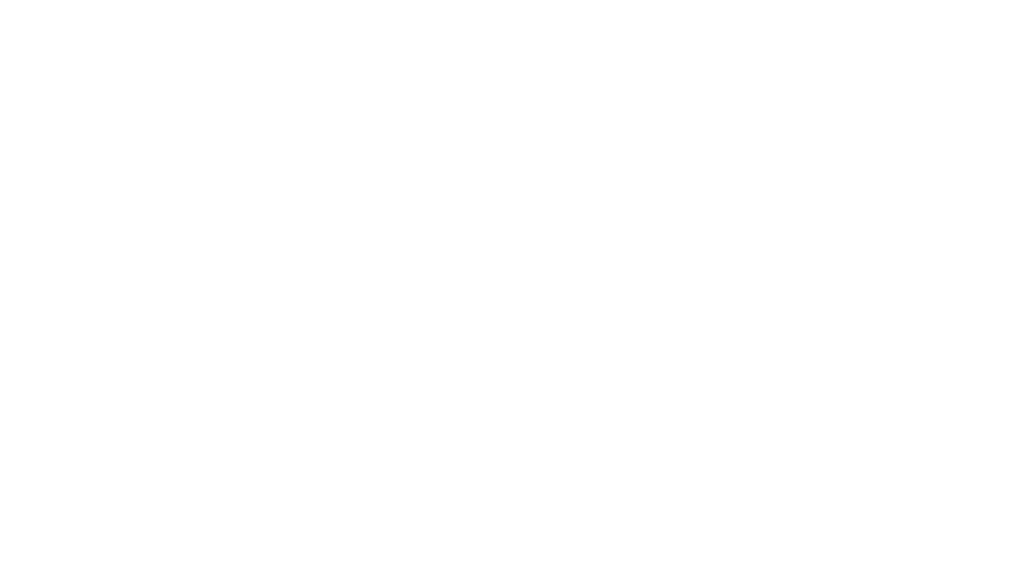

(160, 266, 9)
1208_BaselineA : (160, 266)
(160, 283, 17)
1208_BaselineL : (160, 283) (160, 266)
(160, 193, 14)
1208_BaselineS : (160, 193) (160, 549)
(160, 2, 17)
1208_BaselineL : (160, 2)
(160, 14)
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1222_BaselineA
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


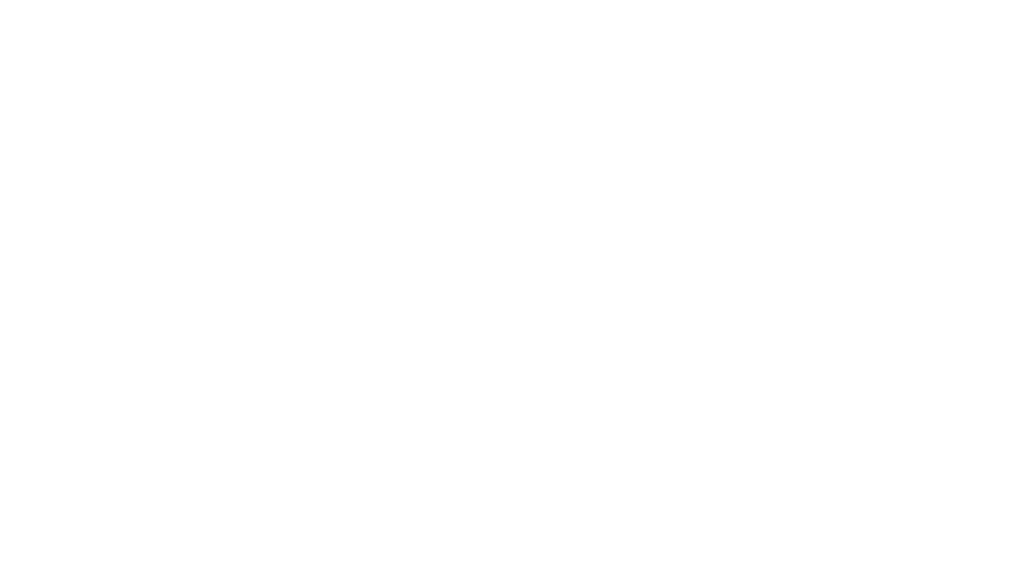

(160, 44, 3)
1222_BaselineA : (160, 44)
(160, 110, 17)
1222_BaselineL : (160, 110) (160, 44)
(160, 111, 0)
1222_BaselineS : (160, 111) (160, 154)
(160, 17)
(160, 0)
CHIdataH (1, 11900)


/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/dana_z/ssd_2TB/6OHDA/plotUtils.py:47: RuntimeWarning: Mean of empty slice
  d = np.nanmean(aligned,axis=1)
/home/dana_z/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


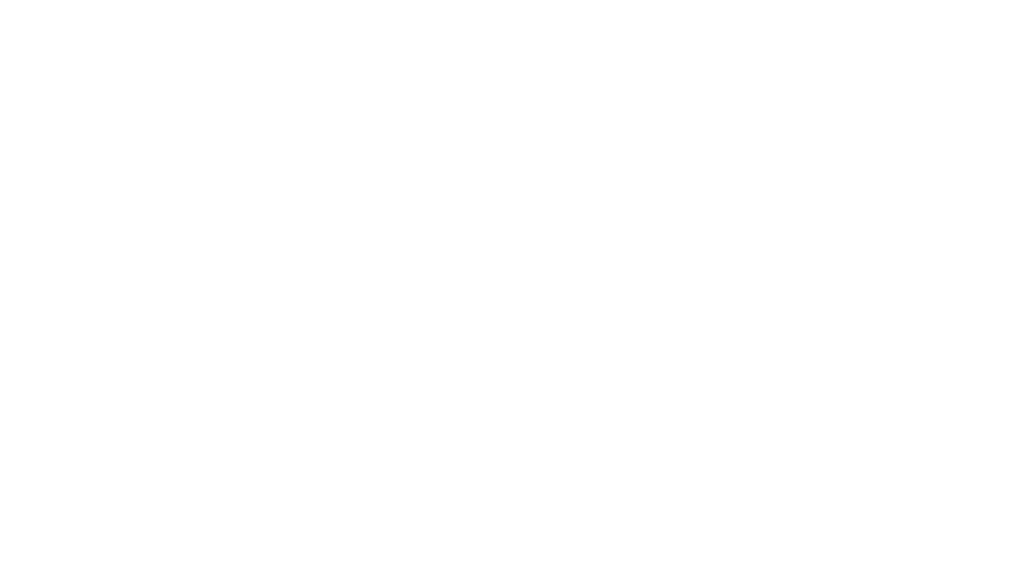

(160, 186, 18)
1231_BaselineA : (160, 186)
(160, 216, 9)
1231_BaselineL : (160, 216) (160, 186)
(160, 177, 3)
1231_BaselineS : (160, 177) (160, 402)
(160, 2, 18)
1231_BaselineA : (160, 2)
(160, 3, 9)
1231_BaselineL : (160, 3) (160, 2)
(160, 2, 3)
1231_BaselineS : (160, 2) (160, 5)
cleaning up trace data
I deleted session: 1236_BaselineL
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


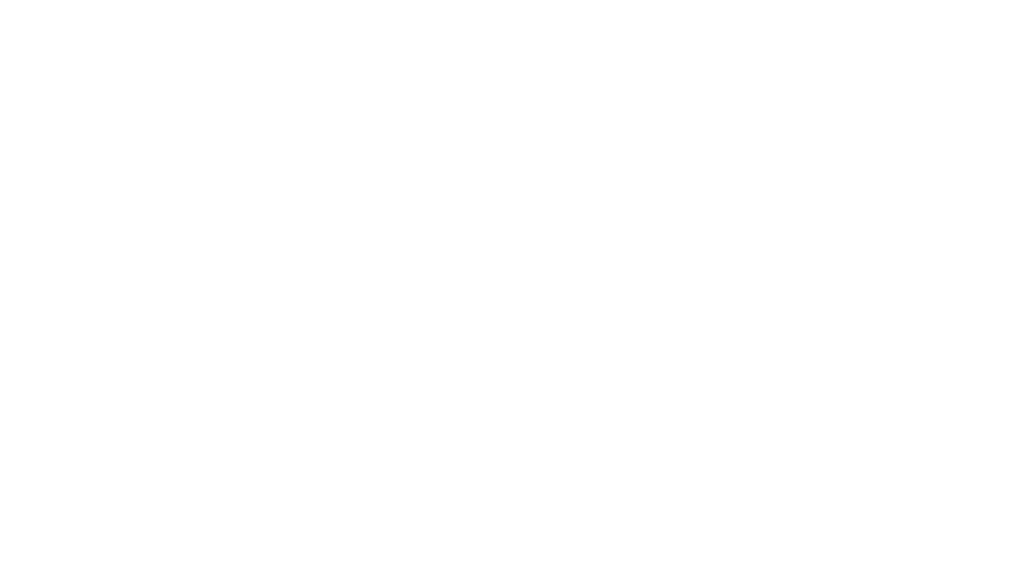

(160, 2, 14)
1236_BaselineA : (160, 2)
(160, 2, 15)
1236_BaselineS : (160, 2) (160, 2)
(160, 189, 14)
1236_BaselineA : (160, 189)
(160, 89, 13)
1236_BaselineL : (160, 89) (160, 189)
(160, 177, 15)
1236_BaselineS : (160, 177) (160, 278)
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1253_BaselineS
cleaning up speed data
cleaning up trace data
I deleted session: 1253_BaselineA
I deleted session: 1253_BaselineS
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


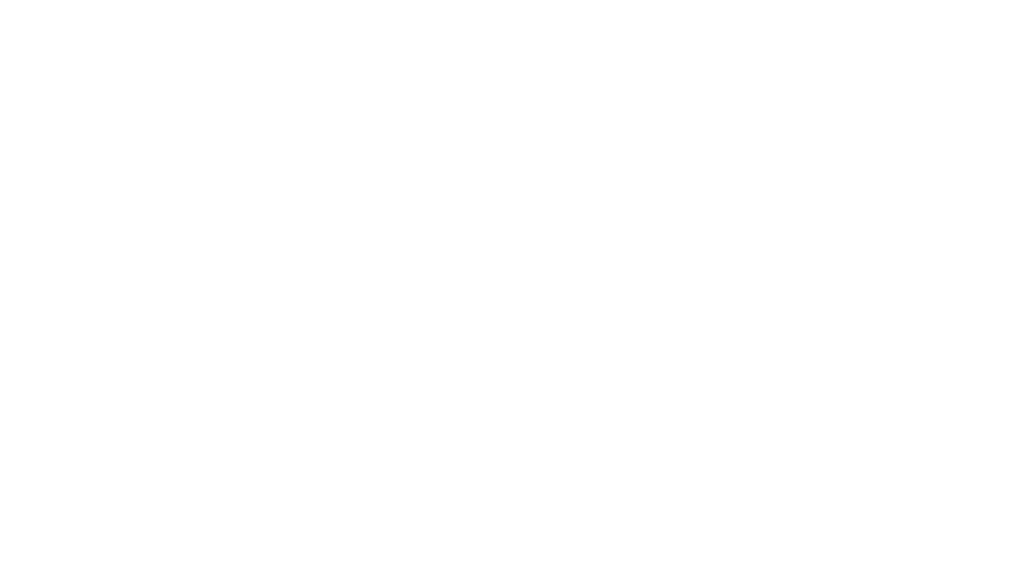

(160, 196, 4)
1253_BaselineA : (160, 196)
(160, 259, 6)
1253_BaselineL : (160, 259) (160, 196)
(160, 6)
CHIdataH (1, 11900)
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1793_BaselineA
I deleted session: 1793_BaselineS
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


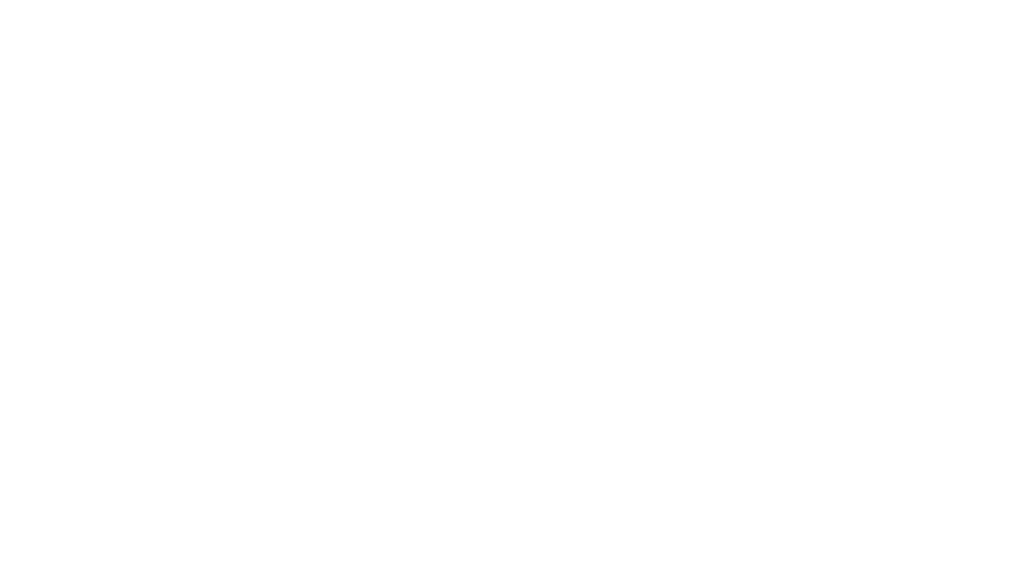

(160, 139, 22)
1793_BaselineA : (160, 139)
(160, 717, 2)
1793_BaselineL : (160, 717) (160, 139)
(160, 502, 18)
1793_BaselineS : (160, 502) (160, 856)
(160, 2, 2)
1793_BaselineL : (160, 2)
cleaning up trace data
I deleted session: 4539_Baseline2A
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 4539_Baseline2A
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


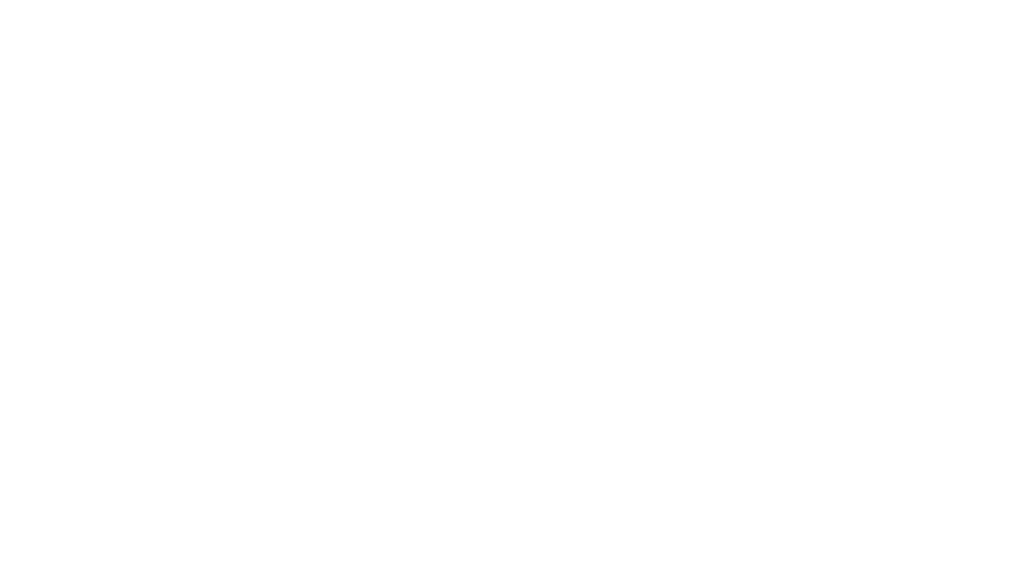

(160, 4, 4)
4539_BaselineA : (160, 4)
(160, 4, 27)
4539_day0 : (160, 4) (160, 4)
(160, 446, 4)
4539_BaselineA : (160, 446)
(160, 226, 27)
4539_day0 : (160, 226) (160, 446)
cleaning up trace data
I deleted session: 7584_day0
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


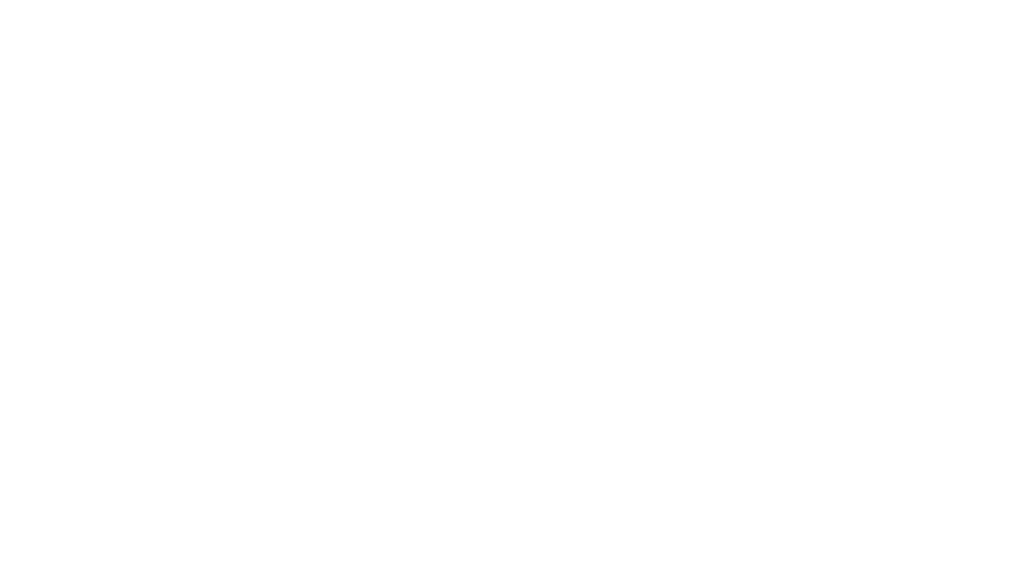

(160, 4, 29)
7584_Baseline0 : (160, 4)
(160, 21)
(160, 212, 29)
7584_Baseline0 : (160, 212)
(160, 33, 21)
7584_BaselineA : (160, 33) (160, 212)
(160, 55, 22)
7584_day0 : (160, 55) (160, 245)
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


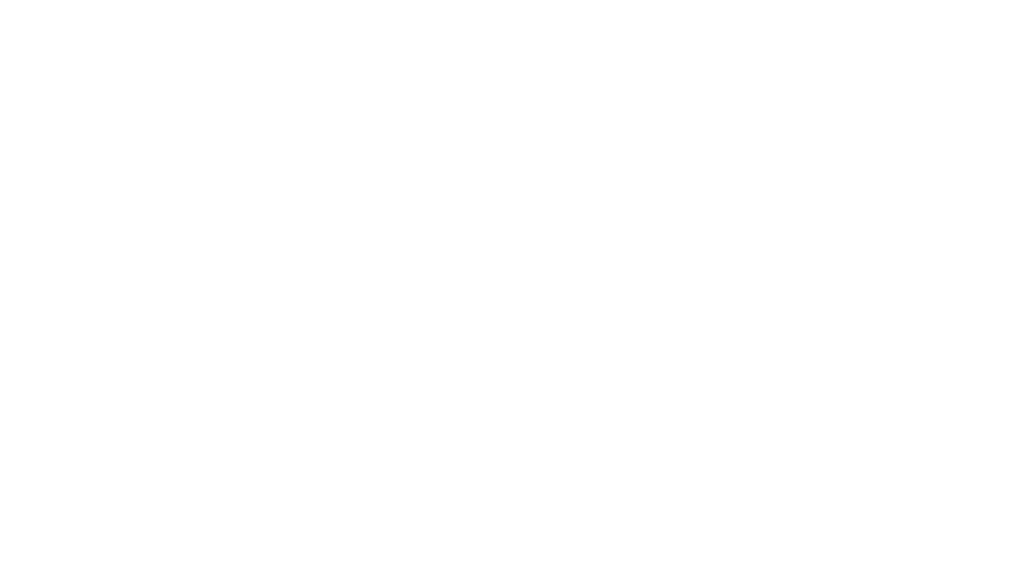

(160, 5, 45)
7909_Baseline2A : (160, 5)
(160, 30)
(160, 515, 45)
7909_Baseline2A : (160, 515)
(160, 169, 30)
7909_BaselineA : (160, 169) (160, 515)
cleaning up trace data
I deleted session: 8430_BaselineA
I deleted session: 8430_BaselineS
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


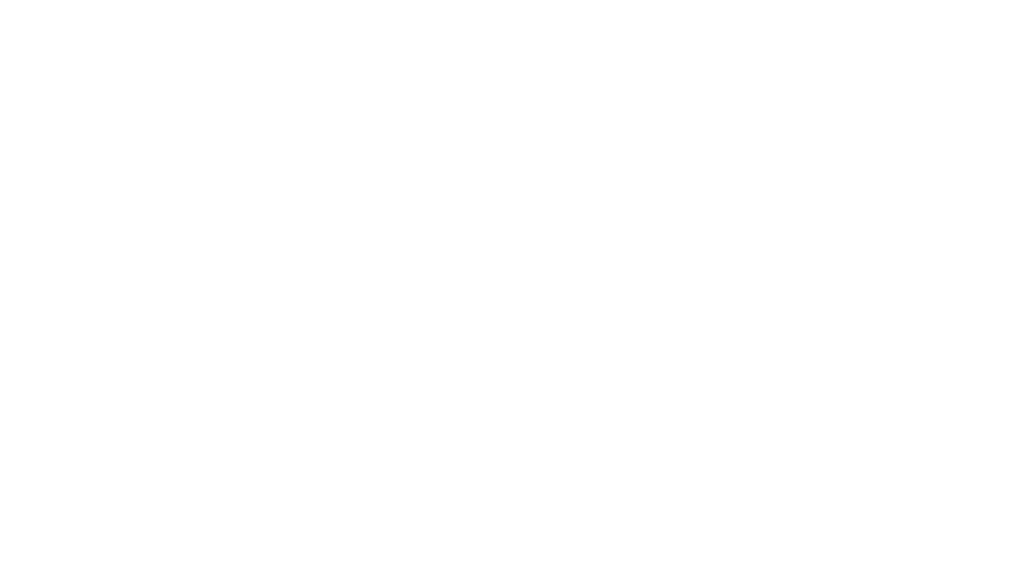

(160, 6)
PVdataH (1, 11900)
(160, 176)
(160, 77, 6)
8430_BaselineL : (160, 77)
(160, 98, 2)
8430_BaselineS : (160, 98) (160, 77)
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


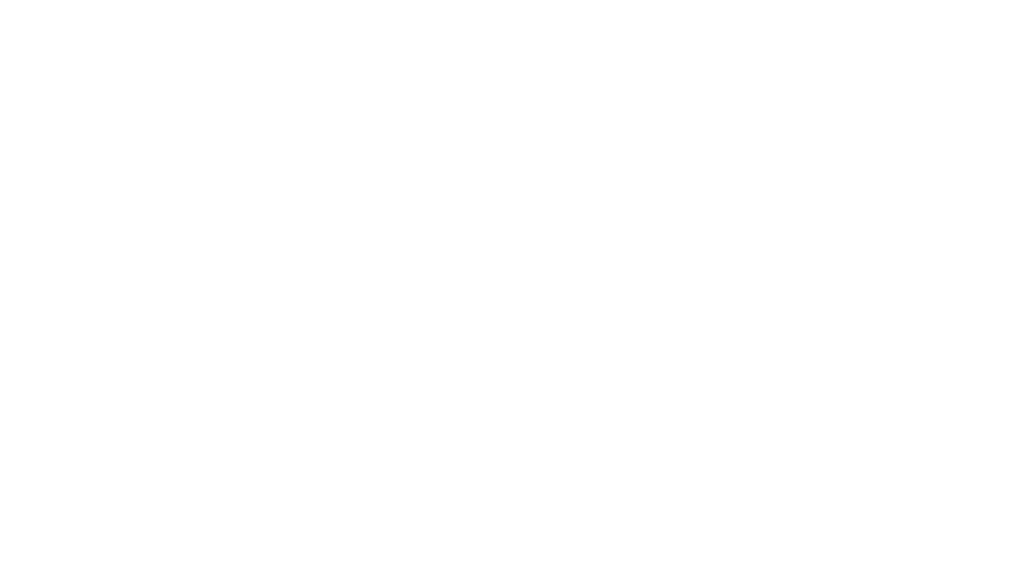

(160,)
(160, 9)
(160, 20)
PVdataH (1, 11900)
(160, 141)
(160, 162, 9)
8803_BaselineL : (160, 162)
(160, 159, 20)
8803_BaselineS : (160, 159) (160, 162)
cleaning up trace data
cleaning up trace data
cleaning up speed data
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 8815_BaselineL
cleaning up trace data
cleaning up speed data


<IPython.core.display.Javascript object>


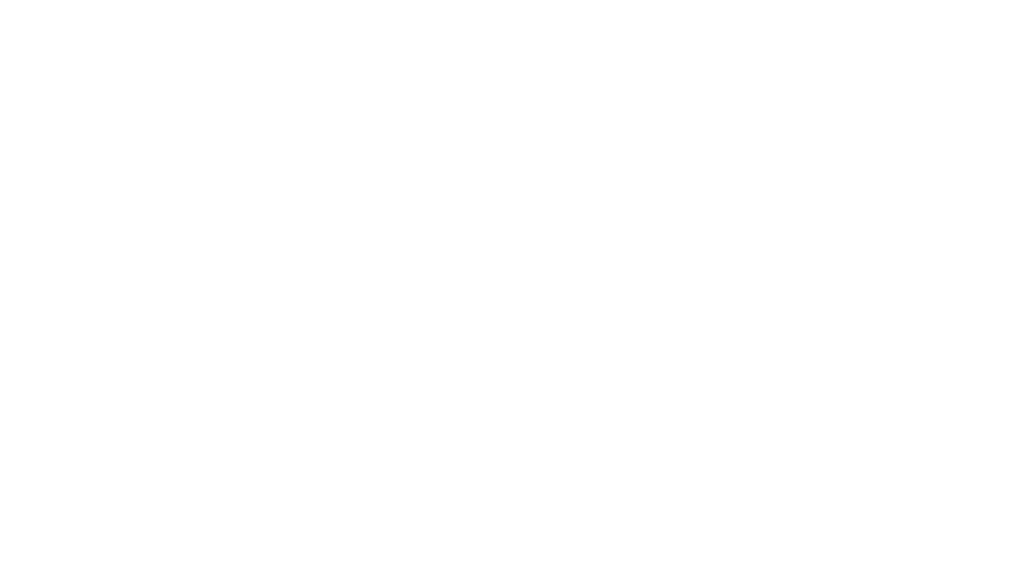

(160, 74, 4)
8815_BaselineA : (160, 74)
(160, 60, 9)
8815_BaselineL : (160, 60) (160, 74)
(160, 52, 3)
8815_BaselineS : (160, 52) (160, 134)
(160, 4, 4)
8815_BaselineA : (160, 4)
(160, 4, 3)
8815_BaselineS : (160, 4) (160, 4)


In [44]:
# define presentation params:
prs = Presentation()
prs.slide_width = Inches(11)
title_layout = prs.slide_layouts[5] 
title_slide_layout = prs.slide_layouts[0]

slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = 'Ca Aligned to mvmt onset'
# define figure params:
lf = {'left':0.30, 'top':1.30, 'height':5.80, 'width':10.10}
fArgs = {'left':Inches(lf['left']),'top':Inches(lf['top']), 'height':Inches(lf['height']), 'width':Inches(lf['width'])}

Colors = CP('creType')

cond = ['PVdataH','MSNdataH','CHIdataH']
Names = {'PVdataH':'PV - healthy','PVdataP':'PV - post 6OHDA',
         'MSNdataH':'MSN - healthy','MSNdataP':'MSN - post 6OHDA',
         'CHIdataH':'CHI - healthy','CHIdataP':'CHI - post 6OHDA'}

# set the time range to plot: (Assuming all data is in 20Hz, if dataset changes, change this!)
preS = 80 #2s
PostS = 80 # 2s
dt = 0.05

tPlot = np.linspace(-preS*dt,PostS*dt,preS+PostS)

# set mvmt onset params: 
th = 2
hi = 9 
hiWin=40 
thWin=30
shift=1

# get mice list:
miceList = getMiceList('Data_6OHDA_Hc.h5')
# prepare data storage for segments:
# make plot and save as ppt
for m in miceList:
    PVdataH = getData('Data_6OHDA_Hc.h5',['speed','trace'],period ='Pre', cre='PV', mice=m,red = True,day = lambda x: x==0)
    MSNdataH = getData('Data_6OHDA_Hc.h5',['speed','trace'],period ='Pre',red = False, mice=m,day = lambda x: x==0)
    CHIdataH = getData('Data_6OHDA_Hc.h5',['speed','trace'],period ='Pre', cre='CHI',red = True, mice=m,day = lambda x: x==0)
    
    fig, ax = plt.subplots(1,2,figsize=(lf['width'],lf['height']),
                           gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.1})
    fig.set_size_inches(lf['width'],lf['height'],forward=True)
    slide = prs.slides.add_slide(title_layout)
    slide.shapes.title.text = m 
    
    for c in cond:
        data = eval(c)
        for s in data.keys():
            speed = data[s]['speed']['speed'].T
            dff = data[s]['trace']['dff']
            # Vectors are saved as column vectors so.. transposed to raw vector
            if dff.shape[1] == 1:
                dff = dff.T
            sOnset = FindMvmtOnset(speed,th,hi,hiWin,thWin, shift)        
            sA = alignToOnset(dff.T, sOnset, winPost=PostS,winPre=preS)  
            print(sA.shape)
            if len(sA.shape) > 2:
                sA = np.mean(sA,2)
                if 'sAligned' not in locals():
                    print(s+' :',sA.shape)
                    sAligned = sA
                else:
                    print(s+' :',sA.shape,sAligned.shape)
                    sAligned = np.concatenate((sAligned,sA),axis=1)
        if len(data.keys())==0:
            continue
        if c[-1]=='H':
            try:
                PlotRelativeToOnset(ax[0],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
            except:
                print(c, dff.shape)
                continue
        else: 
            PlotRelativeToOnset(ax[1],sAligned,tPlot,Color=Colors[c[0:-5]],Label=c[0:-5],mesErr=True)
        sS = alignToOnset(speed, sOnset, winPost=PostS,winPre=preS)
        if sS.ndim > 1:
            if 'sAlignedSPV' not in locals():
                sAlignedSPV = sS
            else:
                sAlignedSPV = np.concatenate((sAlignedSPV,sS),axis=1)
        del sAligned
    PlotRelativeToOnset(ax[1],sAlignedSPV,tPlot,Color='black',Label='speed',mesErr=True)
    del sAlignedSPV
    ax[0].legend(fontsize=12)
    ax[0].set_title('Healthy')
    ax[1].legend(fontsize=12)
    ax[1].set_title('post 6OHDA')
    pic = plt2pptx(slide, fig, **fArgs)
    plt.close(fig)

prs.save('ppts/dff2mvmt_onset_Hclean.pptx')

In [40]:
%xdel prs

NameError: name 'prs' is not defined


In [43]:
miceList = getMiceList('Data_6OHDA_H.h5')
print(miceList)

['0761', '1208', '1222', '1231', '1236', '1253', '1793', '4539', '8430', '8803', '8815']
